In [13]:
import pickle, yaml, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# domain helpers
from patchsum.utils import (
    plot_region_with_ROIs, plot_region_with_biomarkers
)
from patchsum.cell_seg_info import (
    get_cell_segmentation_df,
)
from patchsum.raw_bm_info import get_normalized_image_for_region_local
from patchsum.scgp_helpers import construct_region_objs, construct_scgp_single_region_outputs

# agents
from agents.context_curator import ContextCurator
from agents.omics_encoder import OmicsEncoder
from agents.omics_annotator import OmicsAnnotator
from agents.omics_annotator_aggregate import OmicsAnnotatorAggregate
from agents.pathology_scorer import PathologyScorer

import scgp
from patchsum.scgp_helpers import parse_llm_response

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

## 1. Load Metadata

In [7]:
# For full metadata details, please refer to the file: metadata.yaml
meta = yaml.safe_load(open("data/DKD/s255/metadata.yaml", "r"))

root_dir          = meta["root_dir"]
tissue_types      = meta["tissue_types"]
major_phenotypes  = meta["major_phenotypes"]
biomarkers        = meta["biomarkers"]
selected_acq_ids  = meta["selected_acq_ids"]
diagnosis_dict    = meta["diagnosis_dict"]
cell_type_rename  = meta["cell_type_rename"]
background        = meta["background"]

print("### Tissue Types:", tissue_types)
print("\n### Major Phenotypes:", major_phenotypes)

df_diag = pd.DataFrame.from_dict(diagnosis_dict, orient="index", columns=["Diagnosis"])
display(df_diag)

### Tissue Types: ['Kidney']

### Major Phenotypes: Healthy, Diabetic Mellitus, Diabetic Kidney Disease


Diagnosis
s255_c001_v001_r001_reg002        DM
s255_c001_v001_r001_reg003     DKD2B
s255_c001_v001_r001_reg004  DKD2A->B
s255_c001_v001_r001_reg005      DKD3
s255_c001_v001_r001_reg009     DKD2B
s255_c001_v001_r001_reg010     DKD2B
s255_c001_v001_r001_reg011  DKD2A->B
s255_c001_v001_r001_reg012        DM
s255_c001_v001_r001_reg013        DM
s255_c001_v001_r001_reg014        DM
s255_c001_v001_r001_reg015        DM
s255_c001_v001_r001_reg016     DKD2A
s255_c001_v001_r001_reg017  DKD2A->B
s255_c001_v001_r001_reg019     DKD2A
s255_c001_v001_r001_reg020        DM
s255_c001_v001_r001_reg022     DKD2B
s255_c001_v001_r001_reg023        DM

## 2. Context Curation

In [8]:
mem_dir = Path("memory/DKD/s255")
mem_dir.mkdir(parents=True, exist_ok=True)
ctx_pkl = mem_dir/"s255_background_context.pkl"

if ctx_pkl.exists():
    context = pickle.load(open(ctx_pkl, "rb"))
else:
    curator = ContextCurator()
    dialogue_curator = curator.run({
        "tissue_types": ", ".join(tissue_types).lower(),
        "major_phenotypes": major_phenotypes,
        "biomarker_list": biomarkers,
        "background": background,
    })
    context = "---\n" + "\n---\n".join(m.type.upper()+": "+m.content for m in dialogue_curator)
    ctx_pkl.parent.mkdir(parents=True, exist_ok=True)
    pickle.dump(context, open(ctx_pkl, "wb"))
print(context)

---
SYSTEM: 
You are a knowledgeable biological research assistant specializing in spatial omics and multiplexed immunofluorescence data analysis. Your task is to help study regions of interest (ROIs) within a tissue sample.

The tissue sample is derived from the following tissue types: kidney, and it has been collected from patients exhibiting these phenotypes: Healthy, Diabetic Mellitus, Diabetic Kidney Disease.

A series of protein biomarkers were measured in this sample and the ROI, and these biomarkers were used to characterize cells and multi-cellular structures. Your primary responsibilities are:

1. To provide detailed knowledge about the roles and biological functions of the major biomarkers observed in the context of the specified tissues and phenotypes.
2. To explain how these proteins may indicate different structural components of the tissue types: kidney.
3. To annotate ROIs with your knowledge on the biomarkers, tissues, and the phenotypes of the patients: Healthy, Diabe

## 3. Annotate Arbitrary ROIs

### 3-A. Selected ROIs Visualization

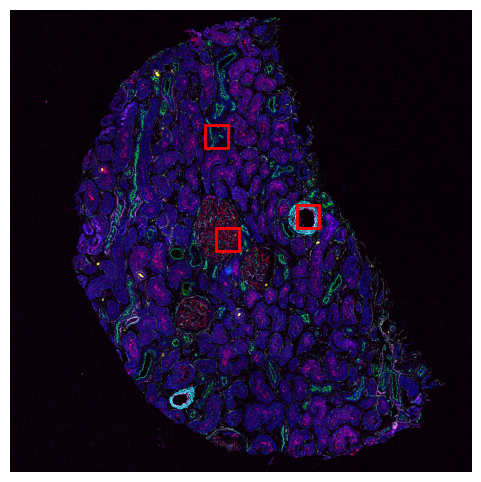

In [14]:
region_id = selected_acq_ids[0]
xyranges = [(2500, 2700, 1700, 1900), (1800, 2000, 1900, 2100), (1700, 1900, 1000, 1200)]

norm_params = pickle.load(open("data/NormParams.pkl", "rb"))
full_img, full_bms = get_normalized_image_for_region_local(
    region_id, root_dir,
    channels=["CD183","CD227","DAPI","Nestin","CD45","aSMA","CollagenIV","Perlecan"],
    norm_params=norm_params)

rendered_img = plot_region_with_biomarkers(
    full_img, full_bms,
    channels=["Nestin","CD227","CD183","CD45","aSMA","Perlecan","CollagenIV"],
    norm_factors=[1,1,1,1,1,2,1])

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(rendered_img); ax.axis("off")
for xmin,xmax,ymin,ymax in xyranges:
    ax.add_patch(plt.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                               edgecolor="red", facecolor="none", linewidth=2))
plt.show()

### 3-B. OmicsEncoder

In [16]:
encoder = OmicsEncoder()
summaries = encoder.run(
    region_id=region_id,
    root_dir=root_dir,
    biomarkers=biomarkers,
    cell_type_rename=cell_type_rename,
    xyranges=xyranges
)

print(summaries['biomarker_summary'][0], summaries['cell_type_summary'][0], summaries['segmentation_summary'][0])

**Highly Expressed Biomarkers**:
These biomarkers are overexpressed:
- **Perlecan**: z-score = 6.8, percentile = 100%
- **CD31**: z-score = 5.3, percentile = 100%
- **aSMA**: z-score = 5.2, percentile = 99%
- **CollagenIV**: z-score = 4.3, percentile = 100%
- **CD141**: z-score = 1.3, percentile = 91%

**Lowly Expressed Biomarkers**:
These biomarkers are underexpressed:
- **CD183**: z-score = -2.4, percentile = 1%
- **CD45**: z-score = -1.8, percentile = 2%
- **CD68**: z-score = -1.5, percentile = 4%
- **EpCAM**: z-score = -1.3, percentile = 1%
- **CD196**: z-score = -1.0, percentile = 1%

**Moderately Expressed Biomarkers**:
These biomarkers do not show strong trends and have moderate expression levels:
**CD227**, **Nestin**, **CD11b**, **VWF** **Major Cell Types**:
1. **Smooth muscle cells (aSMA+)**:
Cells of type "Smooth muscle cells (aSMA+)" make up **52%** of the total composition. They are enriched by **9.6** compared to region average.This cell type is characterized by the bioma

### 3-C. OmicsAnnotator

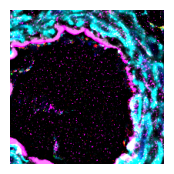

1. **Blood Vessels (Arterioles, Capillaries)**:  
   High expression of vascular-associated biomarkers **Perlecan**, **CD31**, and **CD141** strongly supports localization to blood vessels. Enrichment of **aSMA+** smooth muscle cells further indicates association with arterioles, which have smooth muscle in their walls. The presence of basement membrane markers **CollagenIV** and **Perlecan** aligns with vascular basement membrane structures.  

2. **Interstitial Regions**:  
   Moderate presence of basement membrane components (**CollagenIV**, **Perlecan**) and high density of smooth muscle cells (**aSMA+**) suggest possible involvement in interstitial compartments providing structural support.  

**Other Notable Features**:  
- Cells exhibit elongated morphologies (eccentricity = 0.73) with aligned orientations (low circular variance = 0.29), characteristic of organized vascular structures.  
- Low expression of immune-associated biomarkers (**CD45**, **CD68**) suggests minimal immun

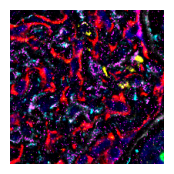

1. **Peritubular Capillaries**:  
   The dominant cell type is endothelial cells (CD31+/CD196+), which make up 58% of the composition and are highly enriched. Biomarker overexpression of CD196, CD31, Nestin, and Perlecan supports localization to vascular structures like peritubular capillaries. The dense spatial organization (high local density, short intercellular distances) aligns with the anatomy of capillaries.  

2. **Glomerular Vascular Pole**:  
   Secondary evidence includes overexpression of Nestin and Perlecan, which are associated with glomerular podocytes and weak glomerular basement membrane staining, respectively. While endothelial cells dominate, the presence of Nestin+ cells suggests proximity to glomerular structures.  

**Other Notable Features**:  
- Cells are smaller than average (25 µm²), reflecting compact vascular morphology.  
- Uniform orientation (low circular variance) indicates alignment typical of endothelial cell arrangements in capillaries.  


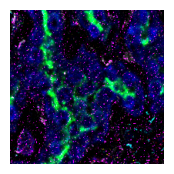

1. Distal Tubules:  
   High expression of **CD227** (z-score = 2.2) and **EpCAM** (z-score = 2.1), both markers strongly associated with distal tubular epithelial cells. These cells constitute 79% of the composition, with significant enrichment (3.4-fold). Dense spatial organization (97th percentile local density) and aligned orientations further support identification as part of the distal tubules.  

2. Collecting Ducts (secondary):  
   Moderate expression of **EpCAM** and **CD227**, which are also localized in collecting ducts, makes this structure a secondary candidate. However, the dominance of distal tubular cells suggests this is less likely.  

Other Notable Features:  
- Sparse immune activity indicated by low **CD68** (z-score = -1.6), suggesting minimal macrophage involvement in this region.  
- Lack of significant smooth muscle presence (**aSMA** underexpressed, z-score = -0.7), indicating the region is unlikely to include vascular structures.  


In [22]:
annotator = OmicsAnnotator()

plot_ROIs = [
    {
        "xyrange": xyr,
        "center_x": (xyr[0] + xyr[1]) // 2,
        "center_y": (xyr[2] + xyr[3]) // 2,
    }
    for xyr in xyranges
]

for i, xyr in enumerate(xyranges):
    rendered_patch = rendered_img[xyr[2] : xyr[3], xyr[0] : xyr[1], :]
    plt.figure(figsize=(2, 2))
    plt.imshow(rendered_patch)
    plt.axis("off")
    plt.show()

    dialogue = annotator.run({
        "tissue_types": ", ".join(tissue_types).lower(),
        "major_phenotypes": major_phenotypes,
        "context": context,
        "bm_summary": summaries["biomarker_summary"][i],
        "ct_summary": summaries["cell_type_summary"][i],
        "seg_summary": summaries["segmentation_summary"][i],
    })
    print(dialogue[-1].content)

## 4. Annotate on SCGP Clusters

### 4-A. Construct SCGP Graphs and Nodes

In [23]:
region_pkl = mem_dir/"s255_region_objs.pkl"
scgp_pkl   = mem_dir/"s255_scgp_single_region_outputs.pkl"

if region_pkl.exists():
    region_objs = pickle.load(open(region_pkl, "rb"))
else:
    region_objs = construct_region_objs(root_dir, selected_acq_ids, biomarkers, cell_type_rename)
    pickle.dump(region_objs, open(region_pkl,"wb"))

if scgp_pkl.exists():
    scgp_single_regions_outputs = pickle.load(open(scgp_pkl,"rb"))
else:
    scgp_single_regions_outputs = construct_scgp_single_region_outputs(region_objs, selected_acq_ids)
    pickle.dump(scgp_single_regions_outputs, open(scgp_pkl,"wb"))

### 4-B. Encode SCGP Single Region

In [24]:
subset_vars = {}
encoder = OmicsEncoder()
for region_id in tqdm(selected_acq_ids, desc="encode SCGP clusters"):
    summaries, cluster_ids = encoder.run_scgp(
    region_id=region_id,
    root_dir=root_dir,
    biomarkers=biomarkers,
    cell_type_rename=cell_type_rename,
    region_objs=region_objs,
    scgp_single_region_outputs=scgp_single_regions_outputs,
    )

    for i, ident in enumerate(cluster_ids):
        subset_vars[ident] = {
            "tissue_types": ", ".join(tissue_types).lower(),
            "major_phenotypes": major_phenotypes,
            "context": context,
            "bm_summary": summaries["biomarker_summary"][i],
            "ct_summary": summaries["cell_type_summary"][i],
            "seg_summary": summaries["segmentation_summary"][i],
        }
pickle.dump(subset_vars, open(mem_dir/"s255_text_inference_scgp-benchmark_vars.pkl","wb"))

encode SCGP clusters: 100%|██████████| 17/17 [04:02<00:00, 14.27s/it]


### 4-C. Single ROI Annotation

In [25]:
annotator = OmicsAnnotator()
results_pkl   = mem_dir/"s255_text_inference_scgp-benchmark_results.pkl"

if results_pkl.exists():
    context = pickle.load(open(ctx_pkl, "rb"))
    scgp_text_inferences = pickle.load(open(results_pkl, 'rb'))
    subset_inputs = scgp_text_inferences['subset_inputs']
    subset_outputs = scgp_text_inferences['subset_outputs']
else:
    subset_inputs, subset_outputs = {}, {}

    for ident, ctx in tqdm(subset_vars.items(), desc="LLM per ROI"):
        dlg = annotator.run(ctx)
        subset_inputs[ident]  = dlg[2].content
        subset_outputs[ident] = dlg[4].content
    pickle.dump({"subset_inputs":subset_inputs,"subset_outputs":subset_outputs},
                open(mem_dir/'s255_text_inference_scgp-benchmark_results.pkl','wb'))

<Figure size 640x480 with 0 Axes>

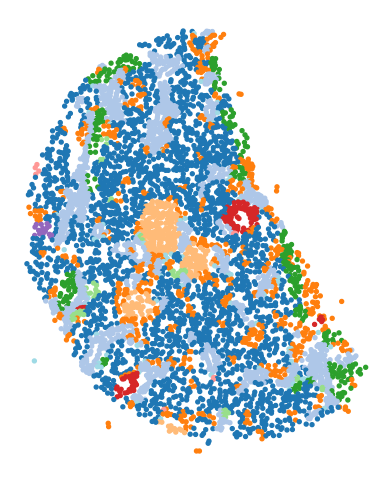

0 ['1. **Renal Tubules (Proximal/Distal)**:  \n', '2. **Basement Membrane Adjacent to Tubules**:  \n']
0 ['1. **Proximal and Distal Tubules**:  \n', '2. **Renal Vasculature** (Secondary Candidate):  \n']
0 ['1. **Proximal Tubules**:  \n', '2. **Renal Vasculature**:  \n']
0 ['1. **Proximal Tubules**:  \n', '2. **Distal Tubules**:  \n']
0 ['1. Tubular Structures (Proximal and Distal Tubules):  \n', '2. Interstitial Inflammatory Domain:  \n']
0 ['1. Proximal Tubules:  \n', '2. Endothelial Cell-Rich Microvasculature:  \n']
0 ['1. **Proximal Tubules**:  \n', '2. **Renal Vasculature (Capillaries/Endothelium)**:  \n']
0 ['1. Proximal Tubules:  \n', '2. Renal Vasculature:  \n']
0 ['1. **Proximal Tubules**:  \n', '2. **Renal Interstitium**:  \n']
1 ['1. **Distal Tubule Region**:  \n', '2. **Basement Membrane/Interstitial Domain**:  \n']
1 ['1. **Distal Tubules**:  \n', '2. **Basement Membrane Domains**:  \n']
1 ['1. Distal Tubules:  \n', '2. Collecting Ducts:  \n']
1 ['1. **Distal Tubules**:  \

In [26]:
### Examples ###
plot_region_id = selected_acq_ids[0]
obj, features, model = region_objs[plot_region_id]
region_annotation = {k: v for k, v in scgp_single_regions_outputs.items() if k[0] == plot_region_id}
scgp.plot_all_regions_with_annotations(region_annotation, obj, figsize=6)
for k, resp in subset_outputs.items():
    if k[0] == plot_region_id:
        print(k[-1], parse_llm_response(resp))

### 4-D. Aggregate over Text Inferences

In [33]:
annotator_agg = OmicsAnnotatorAggregate()

if 'outputs_by_cl' in scgp_text_inferences.keys():
    outputs_by_cl = scgp_text_inferences['outputs_by_cl']
else:
    outputs_by_cl = {}
    tmp = {}
    for (r,cids,cl), txt in subset_outputs.items():
        tmp.setdefault((r,cl), []).append(txt)

    for (r,cl), lst in tqdm(tmp.items(), desc="Aggregate clusters"):
        dlg = annotator_agg.run({
            "tissue_types": ", ".join(tissue_types).lower(),
            "major_phenotypes": major_phenotypes,
            "context": context,
            "n_obs": len(lst),
            "results": "\n===\n".join(lst)
        })
        outputs_by_cl[(r,cl)] = dlg[-1].content
    pickle.dump({"subset_inputs":subset_inputs,"subset_outputs":subset_outputs,"outputs_by_cl":outputs_by_cl},
            open(mem_dir/'s255_text_inference_scgp-benchmark_results.pkl','wb'))

s255_c001_v001_r001_reg009 DKD2B


<Figure size 640x480 with 0 Axes>

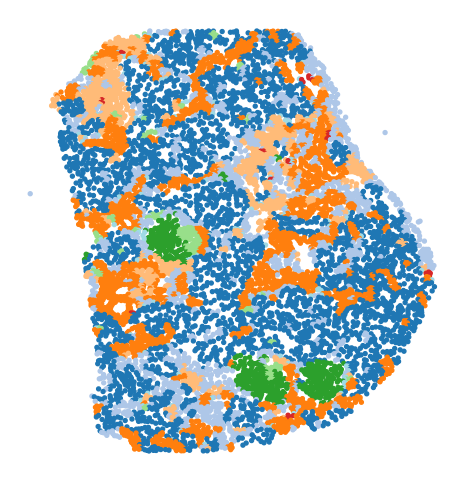

0 ['1. Proximal Tubules:  \n', '2. Peritubular Capillaries:  \n']
===
```
1. Proximal Tubules:  
   The dominant presence of tubular cells (**CD183++/CD227-**) across all ROIs, consistently enriched (76–92%) and aligned with **CD183** overexpression (z-scores up to 1.4, 91st percentile), strongly supports proximal tubule localization. Morphological features such as elongated cells (eccentricity ~0.54–0.57), high circularity (~0.89–0.90), and spatial metrics like moderate local density and intercellular distance further affirm this inference. Additional support comes from moderate expression of **VWF**, **Perlecan**, and **Nestin**, which align with proximal tubular structures and their associated vasculature.

2. Peritubular Capillaries:  
   The moderate-to-high expression of vascular endothelial markers (**VWF**, **CD196**, **CD31**) and the presence of endothelial cells (**CD31+**) in some ROIs suggest proximity to peritubular capillaries. Spatial metrics, such as moderate cell dens

<Figure size 640x480 with 0 Axes>

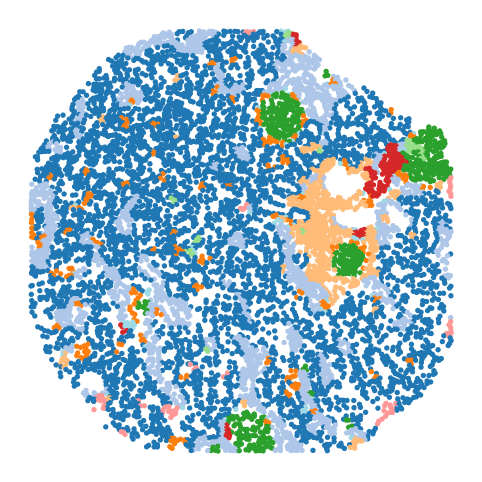

0 ['1. **Proximal Tubules**:  ', '2. **Renal Interstitium**:  ']
===
```
1. **Proximal Tubules**:  
   Supporting Evidence:  
   - Predominance of tubular epithelial cells (CD183++/CD227-), making up 64–86% of the composition across ROIs.  
   - High expression of CD183, a biomarker strongly associated with proximal tubules, observed consistently (z-scores = 0.2–0.8, percentiles = 57–78%).  
   - Morphological metrics such as elongated cell shapes (eccentricity = 0.53–0.56) and moderate cell sizes (46–58 µm²) align with tubular epithelial organization.  
   - Moderate levels of Perlecan and Collagen IV are indicative of tubular basement membrane localization.  

2. **Renal Interstitium**:  
   Supporting Evidence:  
   - Enrichment of immune cells (CD45+, CD68+) observed in several ROIs, with CD68 expression ranging from z-scores = 0.3–1.3 and percentiles = 75–92%, consistent with inflammatory activity in interstitial domains.  
   - Presence of basement membrane cells (CollagenIV+/Per

<Figure size 640x480 with 0 Axes>

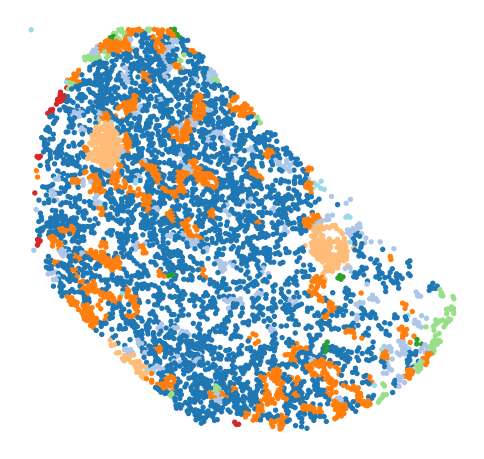

0 ['1. **Proximal Tubules**:  \n', '2. **Renal Vasculature (Peritubular Capillaries/Capillaries)**:  \n']
===
1. **Proximal Tubules**:  
   The dominant cell type across most ROIs is **tubular epithelial cells (CD183++/CD227-)**, constituting 60–85% of the cell population. Biomarkers **CD183** and **Nestin** are highly expressed, consistent with proximal tubules. Additional supporting evidence includes high cell density, moderate circularity, and elongated cell morphology typical of tubular structures. Spatial metrics, such as closely packed cells with small average size, align with proximal tubule organization.

2. **Renal Vasculature (Peritubular Capillaries/Capillaries)**:  
   A secondary structure frequently identified is renal vasculature, supported by the presence of **endothelial cells (CD31+/CD141+)** and vascular markers such as **VWF**, **Perlecan**, and **Collagen IV**. The elongated morphology and sparse organization of endothelial cells further support vascular involvemen

In [35]:
### Examples ###

np.random.seed(123)
for region_id in np.random.choice(selected_acq_ids, (3,), replace=False):
    print(region_id, diagnosis_dict[region_id])
    obj, features, model = region_objs[region_id]
    region_annotation = {k: v for k, v in scgp_single_regions_outputs.items() if k[0] == region_id}
    scgp.plot_all_regions_with_annotations(region_annotation, obj, figsize=6)
    for k, resp in outputs_by_cl.items():
        if k[0] == region_id:
            print(k[-1], parse_llm_response(resp))
            print('===')
            print(resp)
            print('===\n\n')

## 5. Case Study

### 5-A. DKD3 Sample

Diagnosis label: DKD3


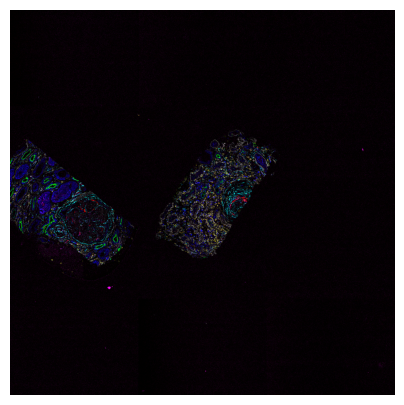

<Figure size 640x480 with 0 Axes>

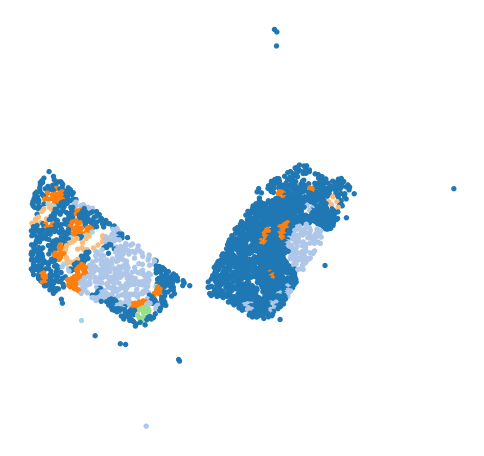

In [27]:
region_id  = "s255_c001_v001_r001_reg005"          # DKD3
# root_dir   = "/autofs/bal14/zqwu/mIF_data/s255"
diagnosis  = diagnosis_dict[region_id]
print("Diagnosis label:", diagnosis)

# ---------- Whole-slide biomarker rendering ----------
full_img, full_bms = get_normalized_image_for_region_local(
    region_id, root_dir,
    channels=["CD183","CD227","DAPI","Nestin","CD45","aSMA","CollagenIV","Perlecan"],
    norm_params=norm_params,
)

rendered_img = plot_region_with_biomarkers(
    full_img, full_bms,
    channels=["Nestin","CD227","CD183","CD45","aSMA","Perlecan","CollagenIV"],
    norm_factors=[1,1,1,1,1,2,1],
)

plt.figure(figsize=(5,5))
plt.imshow(rendered_img)
plt.axis("off")
plt.show()

# ---------- SCGP cluster map ----------
obj, features, model = region_objs[region_id]
region_annotation = {k:v for k,v in scgp_single_regions_outputs.items() if k[0]==region_id}

scgp.plot_all_regions_with_annotations(region_annotation, obj, figsize=6)
plt.show()

In [29]:
# ---------- pick representative subsets ----------
def pick_subset(region_id, cluster_id, index):
    hits = [k for k in subset_inputs if k[0]==region_id and k[-1]==cluster_id]
    assert index < len(hits), "index out of range"
    return hits[index]

fibrotic_glom_subset           = pick_subset(region_id, cluster_id=1, index=1)
inflammed_interstitium_subset  = pick_subset(region_id, cluster_id=0, index=2)

subsets_of_interest = [
    ("DKD3-Fibrotic glomerulus", fibrotic_glom_subset),
    ("DKD3-Inflammed interstitium", inflammed_interstitium_subset),
]

for name, sub in subsets_of_interest:
    print(name, "-- cells:", len(sub[1]))

DKD3-Fibrotic glomerulus -- cells: 119
DKD3-Inflammed interstitium -- cells: 72


<Figure size 640x480 with 0 Axes>

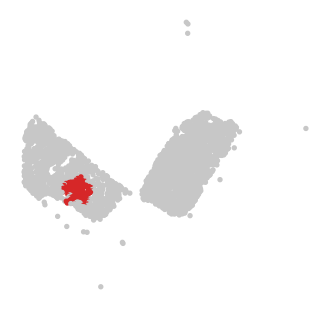

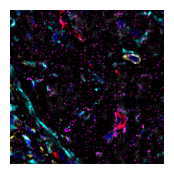

▼ DKD3-Fibrotic glomerulus
1. **Basement Membrane (Glomerular or Tubular)**:  
   The highly expressed biomarkers **Perlecan** (z-score = 1.7, 96th percentile) and **CollagenIV** (z-score = 1.5, 92nd percentile) are classic markers of basement membrane structures. The dominant cell type, "Basement membrane cells (CollagenIV+/Perlecan+)" (37% of total, enrichment = 3.7), strongly supports this inference. The smaller cell size (16 µm², 7th percentile) and high solidity (0.93) align with the compact and dense morphology of basement membrane-associated cells.

2. **Renal Interstitium (Secondary)**:  
   The presence of **Smooth muscle cells (aSMA+)** (29% of total, enrichment = 2.5) and **Nestin+ cells** (17% of total, enrichment = 6.8) suggests potential involvement of the renal interstitium. **aSMA** indicates interstitial fibroblasts or vascular smooth muscle cells, while **Nestin** is often associated with endothelial cells or progenitor-like interstitial populations.

**Other Notable 

<Figure size 640x480 with 0 Axes>

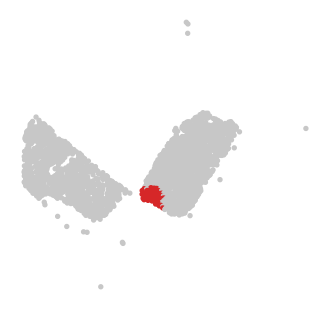

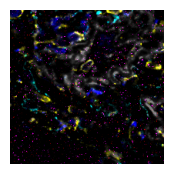

▼ DKD3-Inflammed interstitium
1. **Inflammatory Domain**:  
   The high expression of **CD45** and **CD68**, alongside the presence of **CD45+** immune cells (22% of composition) and **CD45+/CD11b+** immune cells (3% of composition), strongly indicates an inflammatory domain. These biomarkers and cell types are associated with immune cell infiltration, which is common in pathological states such as diabetic kidney disease. Additionally, low expression of **Perlecan** suggests reduced basement membrane integrity, which often accompanies inflammation.

2. **Renal Interstitium** (Secondary):  
   Moderate expression of **CollagenIV** and the presence of **Basement membrane cells (CollagenIV+/Perlecan+)** (17% of composition) suggest involvement of the renal interstitium, which provides structural support and is a site of immune activity during disease progression. Enrichment of low-expressing cells may also reflect interstitial remodeling or fibrotic changes.

**Other Notable Features**: 

In [31]:
# ---------- pathology scoring with plots ----------
dr_cache = Path("memory/DKD/s255/s255_disease-relevant_dialogues.pkl")
if dr_cache.exists():
    dr_dialogues = pickle.load(open(dr_cache, "rb"))
else:
    dr_dialogues = {}

scorer = PathologyScorer()

cell_seg_df = get_cell_segmentation_df(region_id, root_dir)
plot_ROIs = []

for name, subset in subsets_of_interest:
    # -------- Plot patch region for each subset --------
    cids = subset[1]
    coords = cell_seg_df.set_index("CELL_ID").loc[cids, ["X", "Y"]].values
    x_center, y_center = np.median(coords, axis=0).astype(int)
    xyr = (x_center-100, x_center+100, y_center-100, y_center+100)
    plot_ROIs.append({"xyrange": xyr, "center_x": x_center, "center_y": y_center})

    # Highlight target cells in SCGP plot
    scgp.plot_all_regions_with_annotations(
        {k: 6 if int(k[1]) in subset[1] else 15 for k in region_annotation},
        obj, figsize=4,
    )
    plt.show()

    # Plot cropped image patch
    rendered_patch = rendered_img[xyr[2]:xyr[3], xyr[0]:xyr[1], :]
    plt.figure(figsize=(2, 2))
    plt.imshow(rendered_patch)
    plt.axis("off")
    plt.show()

    # -------- Pathology Scoring --------
    if name in dr_dialogues:
        dialogue = dr_dialogues[name]
    else:
        ctx_vars = {
            "tissue_types"    : ", ".join(tissue_types).lower(),
            "major_phenotypes": major_phenotypes,
            "user_input"      : subset_inputs[subset],
            "ai_output"       : subset_outputs[subset],
            "diagnosis"       : diagnosis,
        }
        dialogue = scorer.run(ctx_vars)
        dr_dialogues[name] = dialogue

    # -------- Output Results --------
    print("▼", name)
    print(dialogue[-3].content)
    print("——" * 20)
    print(dialogue[-1].content)
    print("\n")

### 5-B. DKD2B sample

Diagnosis label: DKD2B


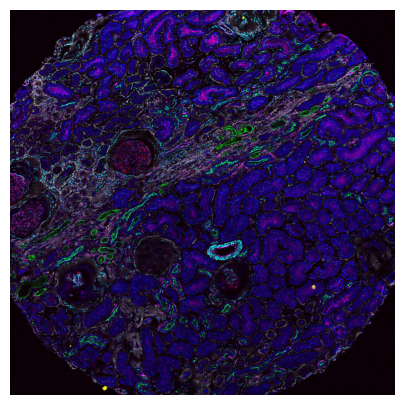

<Figure size 640x480 with 0 Axes>

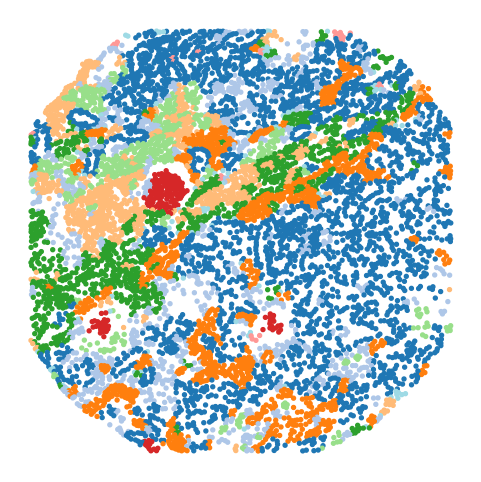

In [32]:
region_id = "s255_c001_v001_r001_reg022"        # DKD2B
diagnosis  = diagnosis_dict[region_id]
print("Diagnosis label:", diagnosis)

# ---------- Whole-slide biomarker rendering ----------
full_img, full_bms = get_normalized_image_for_region_local(
    region_id, root_dir,
    channels=["CD183","CD227","DAPI","Nestin","CD45","aSMA","CollagenIV","Perlecan"],
    norm_params=norm_params,
)
rendered_img = plot_region_with_biomarkers(
    full_img, full_bms,
    channels=["Nestin","CD227","CD183","CD45","aSMA","Perlecan","CollagenIV"],
    norm_factors=[1,1,1,1,1,2,1],
)
plt.figure(figsize=(5,5))
plt.imshow(rendered_img)
plt.axis("off")
plt.show()

# ---------- SCGP cluster map ----------
obj, features, model = region_objs[region_id]
region_annotation = {k:v for k,v in scgp_single_regions_outputs.items() if k[0]==region_id}
scgp.plot_all_regions_with_annotations(region_annotation, obj, figsize=6)
plt.show()

In [33]:
# ---------- pick representative subsets ----------
def pick_subset(region_id, cluster_id, index):
    hits = [k for k in subset_inputs if k[0]==region_id and k[-1]==cluster_id]
    assert index < len(hits), "index out of range"
    return hits[index]

prox_tub_subset       = pick_subset(region_id, cluster_id=0, index=5)   # regular proximal tubule
fibrotic_glom_subset  = pick_subset(region_id, cluster_id=6, index=1)   # fibrotic glomerulus
inflammed_bm_subset   = pick_subset(region_id, cluster_id=3, index=2)   # inflamed BM

names = [
    "DKD2B-Proximal tubules",
    "DKD2B-Glomerulus",
    "DKD2B-Inflammed basement membrane",
]
subsets_of_interest = [prox_tub_subset, fibrotic_glom_subset, inflammed_bm_subset]

for nm, sub in zip(names, subsets_of_interest):
    print(nm, "-- cells:", len(sub[1]))

DKD2B-Proximal tubules -- cells: 62
DKD2B-Glomerulus -- cells: 71
DKD2B-Inflammed basement membrane -- cells: 65


<Figure size 640x480 with 0 Axes>

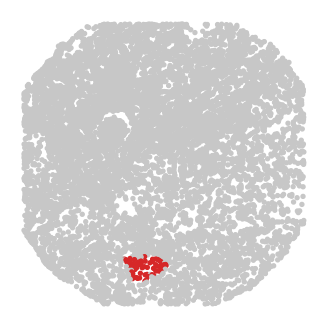

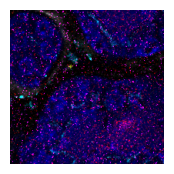

▼ DKD2B-Proximal tubules
1. **Proximal Tubules**:  
   The dominant cell type, "Tubular cells (CD183++/CD227-)" (87% composition), strongly supports localization to the proximal tubules. CD183 is a biomarker frequently associated with proximal tubular epithelial cells, and its overexpression (z-score = 0.5) aligns with this structure. The lack of CD227 expression further distinguishes these cells from distal or collecting duct cells, which typically express CD227. The moderate circularity (0.86) and aligned orientations support epithelial organization typical of tubular structures.

2. **Peritubular Capillaries**:  
   The presence of "Endothelial cells (CD31+)" (8% composition) and the expression of CD31 and CD141 suggest the inclusion of peritubular capillaries in this region. These biomarkers are characteristic of endothelial cells, and their spatial proximity to tubular cells is consistent with kidney microanatomy.

**Other Notable Features**:  
- The low expression of aSMA (z-scor

<Figure size 640x480 with 0 Axes>

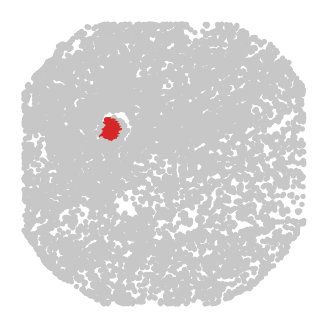

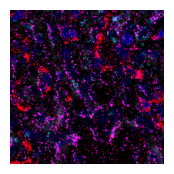

▼ DKD2B-Glomerulus
```
1. Glomeruli:  
   The high expression of **CD196** and **CD31**, coupled with the dominance of **Endothelial cells (CD31+/CD196+)** (49% of total composition), strongly suggests this region is associated with glomeruli. **CD196** and **CD31** are markers for glomerular and peritubular capillary endothelial cells, key components of the glomerular capillary network. The dense packing of cells (94th percentile local density) and their uniform, aligned orientations further align with the structure of glomerular capillaries.

2. Peritubular Capillaries:  
   As a secondary candidate, the presence of **CD31+** endothelial cells (17% of total composition) and moderate expression of **Perlecan** and **Nestin**, which are linked to small vessels, may indicate peritubular capillaries. However, the dominance of **CD196** supports glomeruli as the primary structure.

Other Notable Features:  
- Low expression of immune markers (**CD45**, **CD68**, **CD11b**) suggests minima

<Figure size 640x480 with 0 Axes>

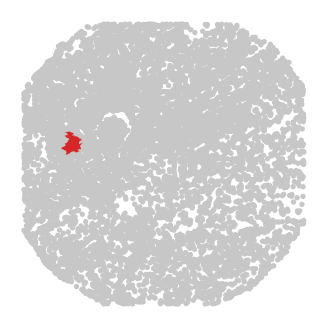

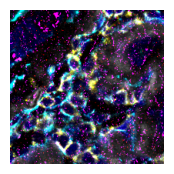

▼ DKD2B-Inflammed basement membrane
1. **Inflammatory Domains**:  
   Supporting Evidence:  
   - High expression of immune-related biomarkers: **CD45** (z-score = 4.9, percentile = 100%) and **CD68** (z-score = 1.7, percentile = 93%), which are markers for immune cells such as hematopoietic cells and macrophages.  
   - Dominant cell composition of **Immune cells (CD45+)** at 77% and **Immune cells (CD45+/CD68+)** at 5%, indicating active immune infiltration.  
   - Dense cell packing (local density in 99th percentile, z-score: 2.9) and shorter intercellular distances (3rd percentile, z-score: -1.6), consistent with inflammatory clusters.  

2. **Renal Interstitium**:  
   Supporting Evidence:  
   - Moderate expression of **CollagenIV** and **Perlecan**, which are characteristic of basement membrane cells and interstitial structures.  
   - Presence of fibroblast-like markers such as **aSMA** (z-score = 2.3, percentile = 97%), which may indicate interstitial remodeling or fibrosis as

In [34]:
# ---------- pathology scoring with plots ----------
dr_cache = Path("memory/DKD/s255/s255_disease-relevant_dialogues.pkl")
dr_dialogues = pickle.load(open(dr_cache, "rb")) if dr_cache.exists() else {}

scorer = PathologyScorer()
cell_seg_df = get_cell_segmentation_df(region_id, root_dir)
plot_ROIs = []

for name, subset in zip(names, subsets_of_interest):
    # ROI bounding-box (±100 px around median)
    cids = subset[1]
    coords = cell_seg_df.set_index("CELL_ID").loc[cids, ["X", "Y"]].values
    x_mid, y_mid = np.median(coords, axis=0).astype(int)
    xyr = (x_mid-100, x_mid+100, y_mid-100, y_mid+100)
    plot_ROIs.append({"xyrange": xyr, "center_x": x_mid, "center_y": y_mid})

    # highlight cells on SCGP map
    scgp.plot_all_regions_with_annotations(
        {k: 6 if int(k[1]) in subset[1] else 15 for k in region_annotation},
        obj, figsize=4,
    )
    plt.show()

    # show cropped patch
    patch = rendered_img[xyr[2]:xyr[3], xyr[0]:xyr[1], :]
    plt.figure(figsize=(2,2))
    plt.imshow(patch)
    plt.axis("off")
    plt.show()

    # pathology scorer
    if name in dr_dialogues:
        dialogue = dr_dialogues[name]
    else:
        ctx_vars = {
            "tissue_types"    : ", ".join(tissue_types).lower(),
            "major_phenotypes": major_phenotypes,
            "user_input"      : subset_inputs[subset],
            "ai_output"       : subset_outputs[subset],
            "diagnosis"       : diagnosis,
        }
        dialogue = scorer.run(ctx_vars)
        dr_dialogues[name] = dialogue

    print("▼", name)
    print(dialogue[-3].content)
    print("——" * 20)
    print(dialogue[-1].content)
    print("\n")

### 5-C. DM Sample

Diagnosis label: DM


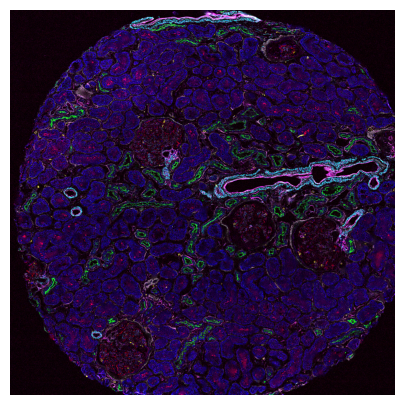

<Figure size 640x480 with 0 Axes>

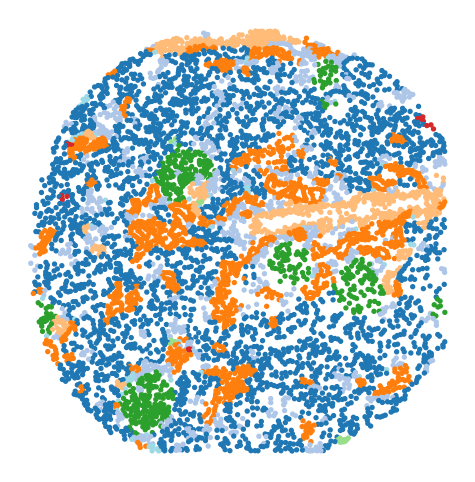

In [35]:
region_id = "s255_c001_v001_r001_reg015"          # DM
diagnosis  = diagnosis_dict[region_id]
print("Diagnosis label:", diagnosis)

# ---------- Whole-slide biomarker rendering ----------
full_img, full_bms = get_normalized_image_for_region_local(
    region_id, root_dir,
    channels=["CD183","CD227","DAPI","Nestin","CD45","aSMA","CollagenIV","Perlecan"],
    norm_params=norm_params,
)
rendered_img = plot_region_with_biomarkers(
    full_img, full_bms,
    channels=["Nestin","CD227","CD183","CD45","aSMA","Perlecan","CollagenIV"],
    norm_factors=[1,1,1,1,1,2,1],
)
plt.figure(figsize=(5,5))
plt.imshow(rendered_img)
plt.axis("off")
plt.show()

# ---------- SCGP cluster map ----------
obj, features, model = region_objs[region_id]
region_annotation = {k:v for k,v in scgp_single_regions_outputs.items() if k[0]==region_id}
scgp.plot_all_regions_with_annotations(region_annotation, obj, figsize=6)
plt.show()

In [36]:
# ---------- pick representative subsets ----------
def pick_subset(region_id, cluster_id, index):
    hits = [k for k in subset_inputs if k[0]==region_id and k[-1]==cluster_id]
    assert index < len(hits), "index out of range"
    return hits[index]

glom_subset      = pick_subset(region_id, cluster_id=4, index=4)  # regular glomerulus
dist_tub_subset  = pick_subset(region_id, cluster_id=2, index=2)  # distal tubule

names = ["DM-Glomerulus", "DM-Distal tubule"]
subsets_of_interest = [glom_subset, dist_tub_subset]

for nm, sub in zip(names, subsets_of_interest):
    print(nm, "-- cells:", len(sub[1]))

DM-Glomerulus -- cells: 57
DM-Distal tubule -- cells: 35


<Figure size 640x480 with 0 Axes>

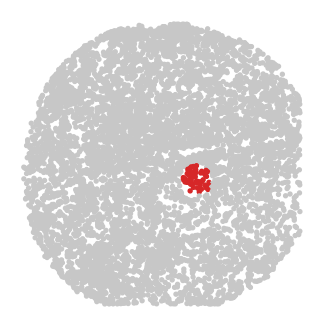

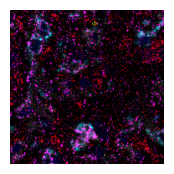

▼ DM-Glomerulus
```
1. Glomeruli:  
   The high expression of **CD31** and **CD196**, both markers of endothelial cells localized in glomeruli and peritubular capillaries, strongly points to the glomerular capillary network. Additionally, the dominance of **Endothelial cells (CD31+/CD196+)** (46%) supports this structure. The moderate expression of **CollagenIV** aligns with the glomerular basement membrane.

2. Peritubular Capillaries:  
   The presence of **Endothelial cells (CD31+)** (12%), combined with **CD31** and low **CD141** expression, suggests involvement of peritubular capillaries as a secondary structure. The spatial metrics, such as moderate cell density and intercellular distances, are consistent with capillary networks.

Other Notable Features:  
- **Elongated Cell Shapes**: High circularity (0.85) and moderate eccentricity (0.54) suggest elongated endothelial morphology typical of capillary structures.  
- **Low Immune Cell Presence**: Immune cells (5%) and moderate **

<Figure size 640x480 with 0 Axes>

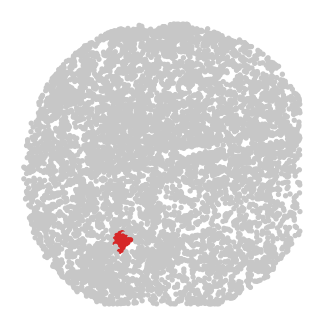

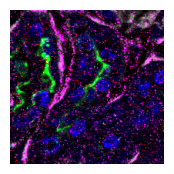

▼ DM-Distal tubule
1. **Distal Tubules (Primary Structure)**:  
   The dominant cell type (89%) is "Distal tubular cells (CD227+)," characterized by high expression of **CD227** (z-score = 1.5) and **EpCAM** (z-score = 2.6), both markers strongly associated with distal tubular epithelial cells. The low expression of **aSMA** (z-score = -0.6) further supports this identification, as smooth muscle actin is not a characteristic feature of tubular structures. The moderate cell size (62 µm²) and aligned cellular orientations (circular variance = 0.19) are consistent with the organized arrangement of cells in distal tubules.

2. **Peritubular Capillaries (Secondary Structure)**:  
   A small population (6%) of **endothelial cells (CD31+)** is present, characterized by markers **CD31** and **CD141**, which are associated with peritubular capillaries. The spatial organization metrics, including relatively low nearest-neighbor distance (12 µm, 28th percentile) and high local density (85th perce

In [37]:
# ---------- pathology scoring with plots ----------
dr_cache = Path("memory/DKD/s255/s255_disease-relevant_dialogues.pkl")
dr_dialogues = pickle.load(open(dr_cache, "rb")) if dr_cache.exists() else {}

scorer = PathologyScorer()
cell_seg_df = get_cell_segmentation_df(region_id, root_dir)
plot_ROIs = []

for name, subset in zip(names, subsets_of_interest):
    # ROI bounding-box (±100 px)
    cids = subset[1]
    coords = cell_seg_df.set_index("CELL_ID").loc[cids, ["X", "Y"]].values
    x_mid, y_mid = np.median(coords, axis=0).astype(int)
    xyr = (x_mid-100, x_mid+100, y_mid-100, y_mid+100)
    plot_ROIs.append({"xyrange": xyr, "center_x": x_mid, "center_y": y_mid})

    # highlight on SCGP map
    scgp.plot_all_regions_with_annotations(
        {k: 6 if int(k[1]) in subset[1] else 15 for k in region_annotation},
        obj, figsize=4,
    )
    plt.show()

    # cropped patch
    patch = rendered_img[xyr[2]:xyr[3], xyr[0]:xyr[1], :]
    plt.figure(figsize=(2,2))
    plt.imshow(patch)
    plt.axis("off")
    plt.show()

    # PathologyScorer
    if name in dr_dialogues:
        dialogue = dr_dialogues[name]
    else:
        ctx_vars = {
            "tissue_types": ", ".join(tissue_types).lower(),
            "major_phenotypes": major_phenotypes,
            "user_input": subset_inputs[subset],
            "ai_output": subset_outputs[subset],
            "diagnosis": diagnosis,
        }
        dialogue = scorer.run(ctx_vars)
        dr_dialogues[name] = dialogue

    print("▼", name)
    print(dialogue[-3].content)
    print("——" * 20)
    print(dialogue[-1].content)
    print("\n")